# 顧客分群：以顧客航班行為進行分析
# Customer Segmentation: Data Analysis Based on Customer Flight Activity

### Introduction

行銷對企業經營是不可或缺的存在，除了能提升品牌認知度、與客戶建立關係，進一步提高銷售。此時若能在先進行顧客分群，便能更有針對性地行銷，來提升不同顧客群的滿意度，並達到資源優化分配的效果。

在這個檔案中，我將分析顧客的最新活動時間(Recency)、消費頻率(Frequency)、飛行距離(Distance)，並進行顧客分群，來幫助企業對其進行相對應的行銷。

### Analysis Steps

1. Preparatory
    * Libraries
    * Data Collection
2. Exploratory Data Analysis (EDA)
3. Analyzing with RFM
    * R(Recency)
    * F(Frequency)
    * M(Monetary)
4. Identifying the Best Cluster Count
    * Elbow method
    * Silhouette analysis
5. Clustering with K-Means
6. Visualizing the Clusters


### Step 1-1 Preparatory：Libraries

* **numpy, pandas**： 用於處理數據結構
* **matplotlib, seaborn**： 用於數據視覺化
* **sklearn**： 提供標準化、分群工具等

In [175]:
import numpy as np
import pandas as pd
from datetime import datetime


import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns


from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

### Step 1-2 Preparatory：Data Collection

* **Source**：Kaggle
* **Dataset**：Airline Loyalty Campaign Program Impact on Flights
* **Document**：Customer Flight Activity.csv
* **About Document**：<br/>
這份資料是關於航空公司的集點活動，裡面包含兩個檔案：一個是顧客的飛行紀錄、另一個是集點與兌換紀錄，這一次使用的是顧客飛行紀錄進行分析，內容包含兩年間的機票預定數、飛行次數、總里程等，這些行為數據將對顧客分群有實際的幫助

In [176]:
url_flight = r"C:\Users\a0920\Documents\GitHub\airline2\Customer Flight Activity.csv"
data_flight = pd.read_csv(url_flight)
data_flight.head()

,Loyalty Number,Year,Month,Flights Booked,Flights with Companions,Total Flights,Distance,Points Accumulated,Points Redeemed,Dollar Cost Points Redeemed
0,100018,2017,1,3,0,3,1521,152.0,0,0
1,100102,2017,1,10,4,14,2030,203.0,0,0
2,100140,2017,1,6,0,6,1200,120.0,0,0
3,100214,2017,1,0,0,0,0,0.0,0,0
4,100272,2017,1,0,0,0,0,0.0,0,0


### Step 2 Exploratory Data Analysis (EDA)

In [177]:
data_flight.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 405624 entries, 0 to 405623
Data columns (total 10 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Loyalty Number               405624 non-null  int64  
 1   Year                         405624 non-null  int64  
 2   Month                        405624 non-null  int64  
 3   Flights Booked               405624 non-null  int64  
 4   Flights with Companions      405624 non-null  int64  
 5   Total Flights                405624 non-null  int64  
 6   Distance                     405624 non-null  int64  
 7   Points Accumulated           405624 non-null  float64
 8   Points Redeemed              405624 non-null  int64  
 9   Dollar Cost Points Redeemed  405624 non-null  int64  
dtypes: float64(1), int64(9)
memory usage: 30.9 MB


In [178]:
print('unique Loyalty Number:',data_flight['Loyalty Number'].nunique())

unique Loyalty Number: 16737


In [179]:
data_flight['Year'].value_counts()

Year
2017    202812
2018    202812
Name: count, dtype: int64

上面段落獲得以下內容：
* 使用info()確認數據數量、空值狀態、數據類型
* 不重複的會員有 16737 位
* 涵蓋年份為 2017-2018
* 兩個年份資料數量是相同的，這有點奇怪，於是進一步查看每個年份的資料數

In [180]:
data_flight.groupby('Year')['Month'].value_counts()


Year  Month
2017  1        16901
      2        16901
      12       16901
      11       16901
      10       16901
      9        16901
      8        16901
      7        16901
      6        16901
      5        16901
      4        16901
      3        16901
2018  11       16901
      10       16901
      9        16901
      8        16901
      7        16901
      6        16901
      5        16901
      4        16901
      3        16901
      2        16901
      1        16901
      12       16901
Name: count, dtype: int64

這裡發現每個月分數量都是相同的，這有點奇怪，於是近一步看看裡面的構成

In [181]:
data_flight['Loyalty Number'].value_counts()

Loyalty Number
678205    72
989528    48
373638    48
684889    48
684881    48
          ..
428526    24
428536    24
428565    24
428590    24
999891    24
Name: count, Length: 16737, dtype: int64

In [182]:
groupby_loyalty = data_flight['Loyalty Number'].value_counts()
unique_values = np.unique(groupby_loyalty.values)
unique_values

array([24, 48, 72], dtype=int64)

這裡發現：
* 每個月份的資料量是相同的
* 所有顧客的飛航記錄總數只有24、48、72，皆為24的倍數，於是我挑選這三種顧客來看看資料分布

In [183]:
filter = data_flight[data_flight['Loyalty Number'] == 546827]
filter.sort_values(['Year','Month'])

,Loyalty Number,Year,Month,Flights Booked,Flights with Companions,Total Flights,Distance,Points Accumulated,Points Redeemed,Dollar Cost Points Redeemed
310563,546827,2017,1,3,2,5,1245,124.0,524,42
25272,546827,2017,2,11,5,16,3232,323.0,0,0
42173,546827,2017,3,0,0,0,0,0.0,0,0
59074,546827,2017,4,0,0,0,0,0.0,0,0
73854,546827,2017,5,13,3,16,3968,396.0,509,41
92876,546827,2017,6,17,0,17,3502,350.0,0,0
109777,546827,2017,7,7,0,7,2884,288.0,0,0
126678,546827,2017,8,10,5,15,2700,270.0,0,0
143579,546827,2017,9,4,3,7,3465,346.0,0,0
160480,546827,2017,10,8,0,8,3456,345.0,0,0


In [184]:
filter_count = filter.groupby(['Year','Month']).count()
filter_count


Loyalty Number  Flights Booked  Flights with Companions  \
Year Month                                                            
2017 1                   1               1                        1   
     2                   1               1                        1   
     3                   1               1                        1   
     4                   1               1                        1   
     5                   1               1                        1   
     6                   1               1                        1   
     7                   1               1                        1   
     8                   1               1                        1   
     9                   1               1                        1   
     10                  1               1                        1   
     11                  1               1                        1   
     12                  1               1                        1   
2018 1                   1               1                        1   
     2                   1               1                        1   
     3                   1               1                        1   
     4                   1               1                        1   
     5                   1               1                        1   
     6                   1               1                        1   
     7                   1               1                        1   
     8                   1               1                        1   
     9                   1               1                        1   
     10                  1               1                        1   
     11                  1               1                        1   
     12                  1               1                        1   

            Total Flights  Distance  Points Accumulated  Points Redeemed  \
Year Month                                                                 
2017 1                  1         1                   1                1   
     2                  1         1                   1                1   
     3                  1         1                   1                1   
     4                  1         1                   1                1   
     5                  1         1                   1                1   
     6                  1         1                   1                1   
     7                  1         1                   1                1   
     8                  1         1                   1                1   
     9                  1         1                   1                1   
     10                 1         1                   1                1   
     11                 1         1                   1                1   
     12                 1         1                   1                1   
2018 1                  1         1                   1                1   
     2                  1         1                   1                1   
     3                  1         1                   1                1   
     4                  1         1                   1                1   
     5                  1         1                   1                1   
     6                  1         1                   1                1   
     7                  1         1                   1                1   
     8                  1         1                   1                1   
     9                  1         1                   1                1   
     10                 1         1                   1                1   
     11                 1         1                   1                1   
     12                 1         1                   1                1   

            Dollar Cost Points Redeemed  
Year Month                               
2017 1                                1  
     2                                1  
     3              

In [185]:
filter = data_flight[data_flight['Loyalty Number'] == 368073]
filter.sort_values(['Year','Month'])

,Loyalty Number,Year,Month,Flights Booked,Flights with Companions,Total Flights,Distance,Points Accumulated,Points Redeemed,Dollar Cost Points Redeemed
4996,368073,2017,1,0,0,0,0,0.00,0,0
4997,368073,2017,1,0,0,0,0,0.00,0,0
21897,368073,2017,2,0,0,0,0,0.00,0,0
21898,368073,2017,2,0,0,0,0,0.00,0,0
38798,368073,2017,3,0,0,0,0,0.00,0,0
38799,368073,2017,3,0,0,0,0,0.00,0,0
55699,368073,2017,4,10,0,10,2570,257.00,0,0
55700,368073,2017,4,7,4,11,3058,305.00,0,0
72600,368073,2017,5,10,7,17,3604,360.00,0,0
72601,368073,2017,5,2,1,3,2016,201.00,0,0


In [186]:
filter_count = filter.groupby(['Year','Month']).count()
filter_count

Loyalty Number  Flights Booked  Flights with Companions  \
Year Month                                                            
2017 1                   2               2                        2   
     2                   2               2                        2   
     3                   2               2                        2   
     4                   2               2                        2   
     5                   2               2                        2   
     6                   2               2                        2   
     7                   2               2                        2   
     8                   2               2                        2   
     9                   2               2                        2   
     10                  2               2                        2   
     11                  2               2                        2   
     12                  2               2                        2   
2018 1                   2               2                        2   
     2                   2               2                        2   
     3                   2               2                        2   
     4                   2               2                        2   
     5                   2               2                        2   
     6                   2               2                        2   
     7                   2               2                        2   
     8                   2               2                        2   
     9                   2               2                        2   
     10                  2               2                        2   
     11                  2               2                        2   
     12                  2               2                        2   

            Total Flights  Distance  Points Accumulated  Points Redeemed  \
Year Month                                                                 
2017 1                  2         2                   2                2   
     2                  2         2                   2                2   
     3                  2         2                   2                2   
     4                  2         2                   2                2   
     5                  2         2                   2                2   
     6                  2         2                   2                2   
     7                  2         2                   2                2   
     8                  2         2                   2                2   
     9                  2         2                   2                2   
     10                 2         2                   2                2   
     11                 2         2                   2                2   
     12                 2         2                   2                2   
2018 1                  2         2                   2                2   
     2                  2         2                   2                2   
     3                  2         2                   2                2   
     4                  2         2                   2                2   
     5                  2         2                   2                2   
     6                  2         2                   2                2   
     7                  2         2                   2                2   
     8                  2         2                   2                2   
     9                  2         2                   2                2   
     10                 2         2                   2                2   
     11                 2         2                   2                2   
     12                 2         2                   2                2   

            Dollar Cost Points Redeemed  
Year Month                               
2017 1                                2  
     2                                2  
     3              

In [187]:
filter = data_flight[data_flight['Loyalty Number'] == 678205]
filter.sort_values(['Year','Month'])

,Loyalty Number,Year,Month,Flights Booked,Flights with Companions,Total Flights,Distance,Points Accumulated,Points Redeemed,Dollar Cost Points Redeemed
10862,678205,2017,1,0,0,0,0,0.0,0,0
10863,678205,2017,1,0,0,0,0,0.0,0,0
10864,678205,2017,1,0,0,0,0,0.0,0,0
27763,678205,2017,2,0,0,0,0,0.0,0,0
27764,678205,2017,2,0,0,0,0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...
382684,678205,2018,11,11,0,11,1177,117.0,0,0
382685,678205,2018,11,8,1,9,1341,134.0,0,0
399585,678205,2018,12,0,0,0,0,0.0,0,0
399586,678205,2018,12,0,0,0,0,0.0,0,0


In [188]:
filter_count = filter.groupby(['Year','Month']).count()
filter_count

Loyalty Number  Flights Booked  Flights with Companions  \
Year Month                                                            
2017 1                   3               3                        3   
     2                   3               3                        3   
     3                   3               3                        3   
     4                   3               3                        3   
     5                   3               3                        3   
     6                   3               3                        3   
     7                   3               3                        3   
     8                   3               3                        3   
     9                   3               3                        3   
     10                  3               3                        3   
     11                  3               3                        3   
     12                  3               3                        3   
2018 1                   3               3                        3   
     2                   3               3                        3   
     3                   3               3                        3   
     4                   3               3                        3   
     5                   3               3                        3   
     6                   3               3                        3   
     7                   3               3                        3   
     8                   3               3                        3   
     9                   3               3                        3   
     10                  3               3                        3   
     11                  3               3                        3   
     12                  3               3                        3   

            Total Flights  Distance  Points Accumulated  Points Redeemed  \
Year Month                                                                 
2017 1                  3         3                   3                3   
     2                  3         3                   3                3   
     3                  3         3                   3                3   
     4                  3         3                   3                3   
     5                  3         3                   3                3   
     6                  3         3                   3                3   
     7                  3         3                   3                3   
     8                  3         3                   3                3   
     9                  3         3                   3                3   
     10                 3         3                   3                3   
     11                 3         3                   3                3   
     12                 3         3                   3                3   
2018 1                  3         3                   3                3   
     2                  3         3                   3                3   
     3                  3         3                   3                3   
     4                  3         3                   3                3   
     5                  3         3                   3                3   
     6                  3         3                   3                3   
     7                  3         3                   3                3   
     8                  3         3                   3                3   
     9                  3         3                   3                3   
     10                 3         3                   3                3   
     11                 3         3                   3                3   
     12                 3         3                   3                3   

            Dollar Cost Points Redeemed  
Year Month                               
2017 1                                3  
     2                                3  
     3              

每個顧客的月資料數是固定的(1-3)，似乎取決於里程不為零的資料，數量最多的月份，未有里程的資料以0補足，而這些構成每個月固定的資料量。

### step 3 RFM
RFM是什麼

### step 3-1 RFM-R(Recency)

In [189]:
# 將年和月合併，以利後續篩選
# 由於年和月欄位型態為數字，使用 map() 逐一轉為 str 格式來合併
# 最後使用 datetime 轉為時間格式

data_flight['date'] = data_flight['Year'].map(str)+'/'+ data_flight['Month'].map(str)
data_flight['date'] = pd.to_datetime(data_flight['date'])
data_flight['date'] .head()

C:\Users\a0920\AppData\Local\Temp\ipykernel_3004\3245897524.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data_flight['date'] = pd.to_datetime(data_flight['date'])


0   2017-01-01
1   2017-01-01
2   2017-01-01
3   2017-01-01
4   2017-01-01
Name: date, dtype: datetime64[ns]

In [190]:
# 將里程數不為零的紀錄取出來

data_flight_not_zero = data_flight[data_flight['Distance']>0]

# 將同個顧客合併，並找出最近消費日
recent_order = data_flight_not_zero.groupby('Loyalty Number')['date'].max().reset_index()
recent_order

# 不重複顧客為16737位，但資料只有15236筆，推測有1501位是無飛航紀錄的

,Loyalty Number,date
0,100018,2018-12-01
1,100102,2018-12-01
2,100140,2018-11-01
3,100214,2018-12-01
4,100272,2018-11-01
...,...,...
15231,999891,2017-01-01
15232,999902,2018-10-01
15233,999940,2018-12-01
15234,999982,2018-11-01


In [191]:
# 根據最後消費時間，計算出 R (Recency 最近一次消費天數)
# 相減後格式含有日期，例如： 31 days，因此使用 .dt.days 提取日期數字部分

today_date = datetime(2019,1,1)
recent_order['Recency'] = today_date-recent_order['date']
recent_order['Recency'] = recent_order['Recency'].dt.days
recent_order

,Loyalty Number,date,Recency
0,100018,2018-12-01,31
1,100102,2018-12-01,31
2,100140,2018-11-01,61
3,100214,2018-12-01,31
4,100272,2018-11-01,61
...,...,...,...
15231,999891,2017-01-01,730
15232,999902,2018-10-01,92
15233,999940,2018-12-01,31
15234,999982,2018-11-01,61


In [192]:
# 看看最大最小值，確認無異常值
recent_order['Recency'].describe()

count    15236.000000
mean        69.789971
std        107.276665
min         31.000000
25%         31.000000
50%         31.000000
75%         61.000000
max        730.000000
Name: Recency, dtype: float64

## step 3.2: RFM-F(Frequency)

In [193]:
# 計算客人的總消費次數
frequency = data_flight_not_zero.groupby('Loyalty Number')['date'].count().reset_index()
frequency = frequency.rename(columns={'Loyalty Number':'Loyalty Number','date':'Frequency'})
frequency

,Loyalty Number,Frequency
0,100018,20
1,100102,17
2,100140,18
3,100214,14
4,100272,17
...,...,...
15231,999891,1
15232,999902,21
15233,999940,8
15234,999982,3


In [194]:
# 看看最大最小值，確認無異常值
frequency['Frequency'].describe()

count    15236.000000
mean        13.627724
std          5.436330
min          1.000000
25%         11.000000
50%         15.000000
75%         17.000000
max         39.000000
Name: Frequency, dtype: float64

## step 3-3: RFM-M(Monetary)

In [195]:
# 資料本身沒有消費金額
# 這裡假設距離與金額成正比，以距離來替代

distance = data_flight_not_zero.groupby('Loyalty Number')['Distance'].sum().reset_index()
distance

,Loyalty Number,Distance
0,100018,50682
1,100102,40222
2,100140,41252
3,100214,33982
4,100272,40872
...,...,...
15231,999891,2526
15232,999902,57227
15233,999940,23410
15234,999982,5948


In [196]:
# 將距離與消費頻率兩個df合併
# 利用距離/消費次數，算出平均距離

distance_avg = pd.merge(frequency,distance,on='Loyalty Number')
distance_avg['Distance_avg'] = round(distance_avg['Distance']/distance_avg['Frequency'])
distance_avg

,Loyalty Number,Frequency,Distance,Distance_avg
0,100018,20,50682,2534.0
1,100102,17,40222,2366.0
2,100140,18,41252,2292.0
3,100214,14,33982,2427.0
4,100272,17,40872,2404.0
...,...,...,...,...
15231,999891,1,2526,2526.0
15232,999902,21,57227,2725.0
15233,999940,8,23410,2926.0
15234,999982,3,5948,1983.0


In [197]:
# 看看最大最小值，確認無異常值
distance_avg['Distance_avg'].describe()

count    15236.000000
mean      2357.772841
std        372.371373
min        234.000000
25%       2153.000000
50%       2361.000000
75%       2565.000000
max       4800.000000
Name: Distance_avg, dtype: float64

## step 3.4: RFM 合併

In [198]:
# 將三個數值與會員編號合併

rfm = pd.merge(recent_order,distance_avg,on='Loyalty Number')
rfm = rfm[['Loyalty Number','Recency','Frequency','Distance_avg']]
rfm

,Loyalty Number,Recency,Frequency,Distance_avg
0,100018,31,20,2534.0
1,100102,31,17,2366.0
2,100140,61,18,2292.0
3,100214,31,14,2427.0
4,100272,61,17,2404.0
...,...,...,...,...
15231,999891,730,1,2526.0
15232,999902,92,21,2725.0
15233,999940,31,8,2926.0
15234,999982,61,3,1983.0


In [199]:
# 對三個維度數值進行標準化

scaler = StandardScaler()
rfm_normalized = rfm[['Recency','Frequency','Distance_avg']]
rfm_normalized = scaler.fit_transform(rfm_normalized)
rfm_normalized

array([[-0.36160002,  1.17220345,  0.473272  ],
       [-0.36160002,  0.62034251,  0.02209469],
       [-0.08194009,  0.80429615, -0.17663817],
       ...,
       [-0.36160002, -1.03524032,  1.52601905],
       [-0.08194009, -1.95500856, -1.00648215],
       [-0.08194009,  0.06848156, -0.01281784]])

In [200]:
# 標準化後格是為array，所以這裡轉為df
rfm_normalized = pd.DataFrame(rfm_normalized)
rfm_normalized = rfm_normalized.rename(columns={0:'Recency',1:'Frequency',2:'Distance_avg'})


# 將資料依照有無會員編號，分為 rfm_normalized、rfm_normalized_rfm_only
rfm_normalized['Loyalty Number'] = rfm['Loyalty Number']
rfm_normalized_rfm_only = rfm_normalized[['Recency', 'Frequency', 'Distance_avg']]

rfm_normalized

,Recency,Frequency,Distance_avg,Loyalty Number
0,-0.361600,1.172203,0.473272,100018
1,-0.361600,0.620343,0.022095,100102
2,-0.081940,0.804296,-0.176638,100140
3,-0.361600,0.068482,0.185915,100214
4,-0.081940,0.620343,0.124147,100272
...,...,...,...,...
15231,6.154476,-2.322916,0.451787,999891
15232,0.207042,1.356157,0.986218,999902
15233,-0.361600,-1.035240,1.526019,999940
15234,-0.081940,-1.955009,-1.006482,999982


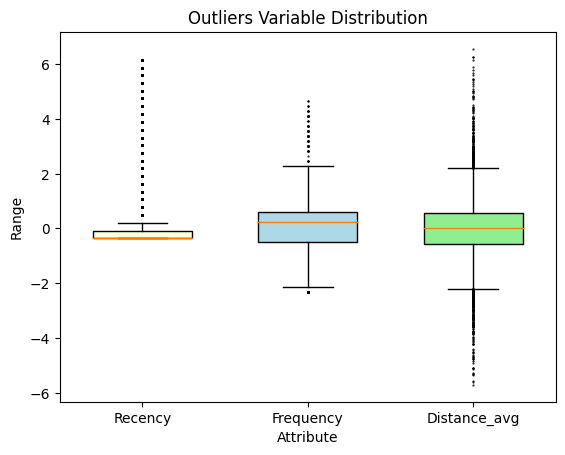

In [201]:
# 將三個維度以箱型圖繪製

# flierprops 定義異常值屬性
flierprops = dict(marker='o', markersize=0.5, markeredgecolor='Black', markerfacecolor='Black') 


# 繪製三個維度的箱子、定義屬性
box1 = plt.boxplot(rfm_normalized['Recency'], positions=[1], widths=0.6, patch_artist=True, flierprops=flierprops)
box2 = plt.boxplot(rfm_normalized['Frequency'], positions=[2], widths=0.6, patch_artist=True, flierprops=flierprops)
box3 = plt.boxplot(rfm_normalized['Distance_avg'], positions=[3], widths=0.6, patch_artist=True, flierprops=flierprops)


# 定義三個箱子的顏色
colors = ['lightyellow', 'lightblue', 'lightgreen']
for box, color in zip([box1, box2, box3], colors):
    for patch in box['boxes']:
        patch.set_facecolor(color)


# 箱型圖命名
plt.xticks([1, 2, 3], ['Recency','Frequency','Distance_avg'])
plt.xlabel('Attribute')
plt.ylabel('Range')
plt.title('Outliers Variable Distribution')
plt.show()

## step 4: 尋找最佳群集數量

k = 1, sse is : 45708.00000000001
k = 2, sse is : 30965.24476712865


k = 3, sse is : 21595.955042325648
k = 4, sse is : 16447.825717402204
k = 5, sse is : 13291.2918288868
k = 6, sse is : 11802.043600103121
k = 7, sse is : 10545.211203716552
k = 8, sse is : 9336.877058675844
k = 9, sse is : 8519.073264643263
k = 10, sse is : 7817.595938225075


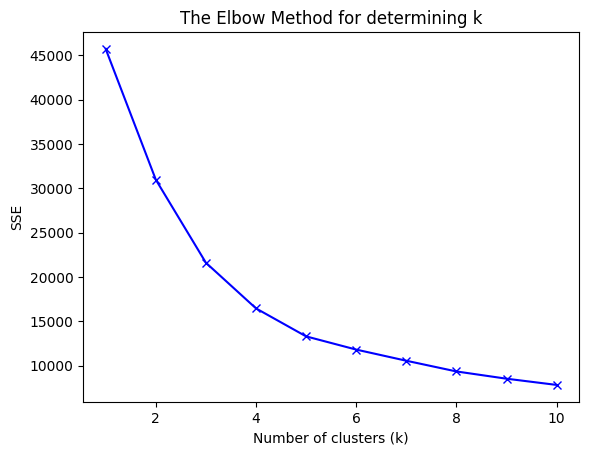

In [202]:
# Elbow method 尋找最佳群集數量

# 以字典形式，儲存每個k值對應的SSE
sse = {}

for k in range(1,11):
    kmeans = KMeans(n_clusters=k, random_state=1)
    kmeans.fit(rfm_normalized_rfm_only)
    sse[k] = kmeans.inertia_
    print(f"k = {k}, sse is : {kmeans.inertia_}")

plt.figure()
plt.plot(list(sse.keys()), list(sse.values()), 'bx-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('SSE')
plt.title('The Elbow Method for determining k')
plt.show()

In [203]:
'''
# 輪廓分析尋找最佳群集數量

# 定義空list，用來存儲每個k值的平均輪廓分數
silhouette_avg_scores = {}


# 計算每個k值的平均輪廓分數，輪廓分析的分群必須從2開始
for n_clusters in range(2,6):
    # 執行k-means聚類
    # fit_predict 用於訓練，並且返回分配的集群標籤
    clusterer = KMeans(n_clusters=n_clusters, random_state=1)
    cluster_labels = clusterer.fit_predict(rfm_normalized_rfm_only)


    # 計算所有點的平均輪廓分數：silhouette_score(df,集群標籤)
    # f-string 可將當前變量帶入{}中
    silhouette_avg = silhouette_score(rfm_normalized_rfm_only, cluster_labels)
    silhouette_avg_scores[n_clusters] = silhouette_avg
    print(f"For n_clusters = {n_clusters}, the average silhouette_score is : {silhouette_avg}")


# 繪製輪廓分數
plt.plot(list(silhouette_avg_scores.keys()),list(silhouette_avg_scores.values()), 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Average Silhouette Score')
plt.title('Silhouette Analysis For Optimal k')
plt.show()

'''

'\n# 輪廓分析尋找最佳群集數量\n\n# 定義空list，用來存儲每個k值的平均輪廓分數\nsilhouette_avg_scores = {}\n\n\n# 計算每個k值的平均輪廓分數，輪廓分析的分群必須從2開始\nfor n_clusters in range(2,6):\n    # 執行k-means聚類\n    # fit_predict 用於訓練，並且返回分配的集群標籤\n    clusterer = KMeans(n_clusters=n_clusters, random_state=1)\n    cluster_labels = clusterer.fit_predict(rfm_normalized_rfm_only)\n\n\n    # 計算所有點的平均輪廓分數：silhouette_score(df,集群標籤)\n    # f-string 可將當前變量帶入{}中\n    silhouette_avg = silhouette_score(rfm_normalized_rfm_only, cluster_labels)\n    silhouette_avg_scores[n_clusters] = silhouette_avg\n    print(f"For n_clusters = {n_clusters}, the average silhouette_score is : {silhouette_avg}")\n\n\n# 繪製輪廓分數\nplt.plot(list(silhouette_avg_scores.keys()),list(silhouette_avg_scores.values()), \'bx-\')\nplt.xlabel(\'Number of Clusters (k)\')\nplt.ylabel(\'Average Silhouette Score\')\nplt.title(\'Silhouette Analysis For Optimal k\')\nplt.show()\n\n'

分析最佳群集數量：
* elbow method：4開始，sse降幅趨緩
* 輪廓分析：4以前有較佳的輪廓分數
* 所以這邊以4作為分群數字

## step 5: k-means

In [204]:
## 分群並標上 label

kmeans = KMeans(n_clusters=4, max_iter=50)
kmeans.fit(rfm_normalized_rfm_only)
rfm_normalized['cluster'] = kmeans.labels_
rfm_normalized

,Recency,Frequency,Distance_avg,Loyalty Number,cluster
0,-0.361600,1.172203,0.473272,100018,1
1,-0.361600,0.620343,0.022095,100102,1
2,-0.081940,0.804296,-0.176638,100140,1
3,-0.361600,0.068482,0.185915,100214,1
4,-0.081940,0.620343,0.124147,100272,1
...,...,...,...,...,...
15231,6.154476,-2.322916,0.451787,999891,2
15232,0.207042,1.356157,0.986218,999902,1
15233,-0.361600,-1.035240,1.526019,999940,0
15234,-0.081940,-1.955009,-1.006482,999982,3


## step 6: 分群作圖

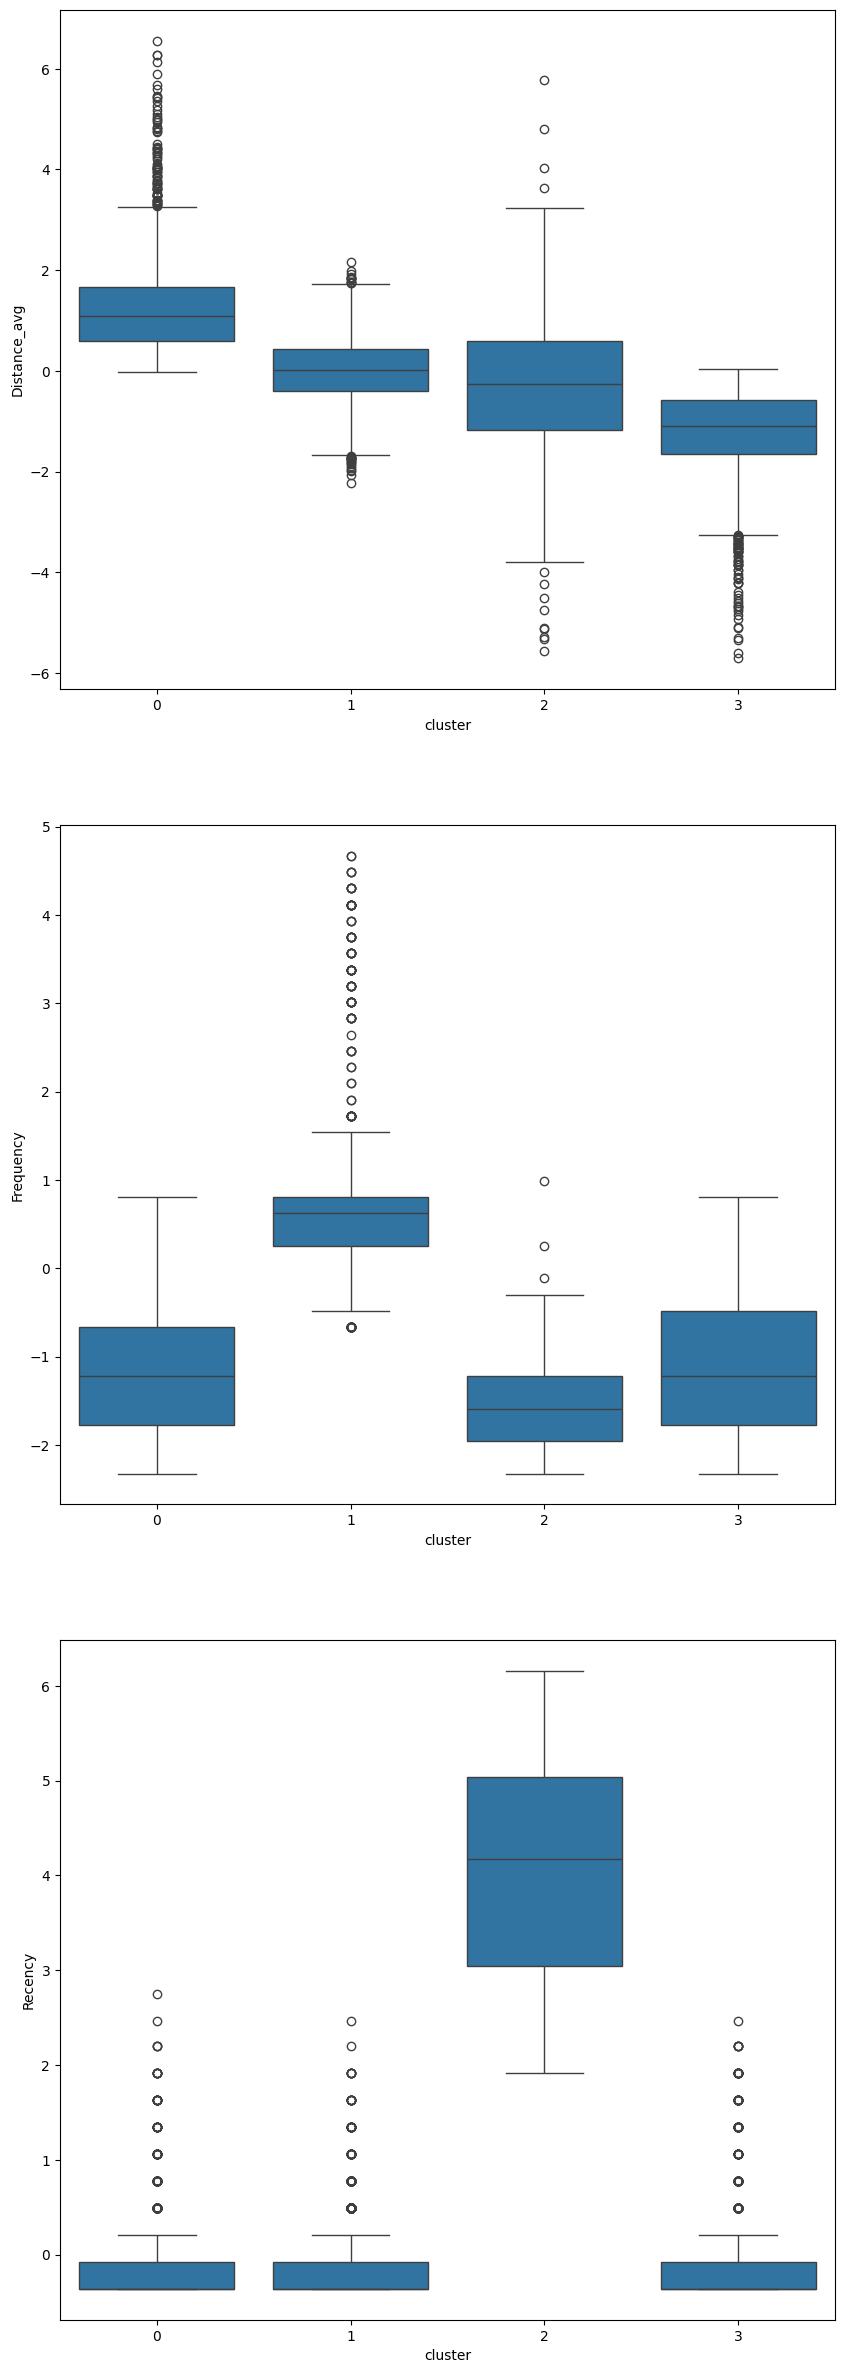

In [205]:
# 單一維度 vs 分群的箱型圖
# 製作一个3x1的組圖
fig, axs = plt.subplots(3, 1, figsize=(10, 30))

sns.boxplot(x='cluster', y='Distance_avg', data=rfm_normalized,ax=axs[0])
sns.boxplot(x='cluster', y='Frequency', data=rfm_normalized,ax=axs[1])
sns.boxplot(x='cluster', y='Recency', data=rfm_normalized,ax=axs[2])

plt.show()

以下為四個群組(需重新編排)
* 群組0：近期有搭乘，平均距離較長的族群
* 群組1：近期有搭乘，總次數較多的族群
* 群組2：近期有搭乘，特性較不突出的族群
* 群組3：比較久沒搭乘的人

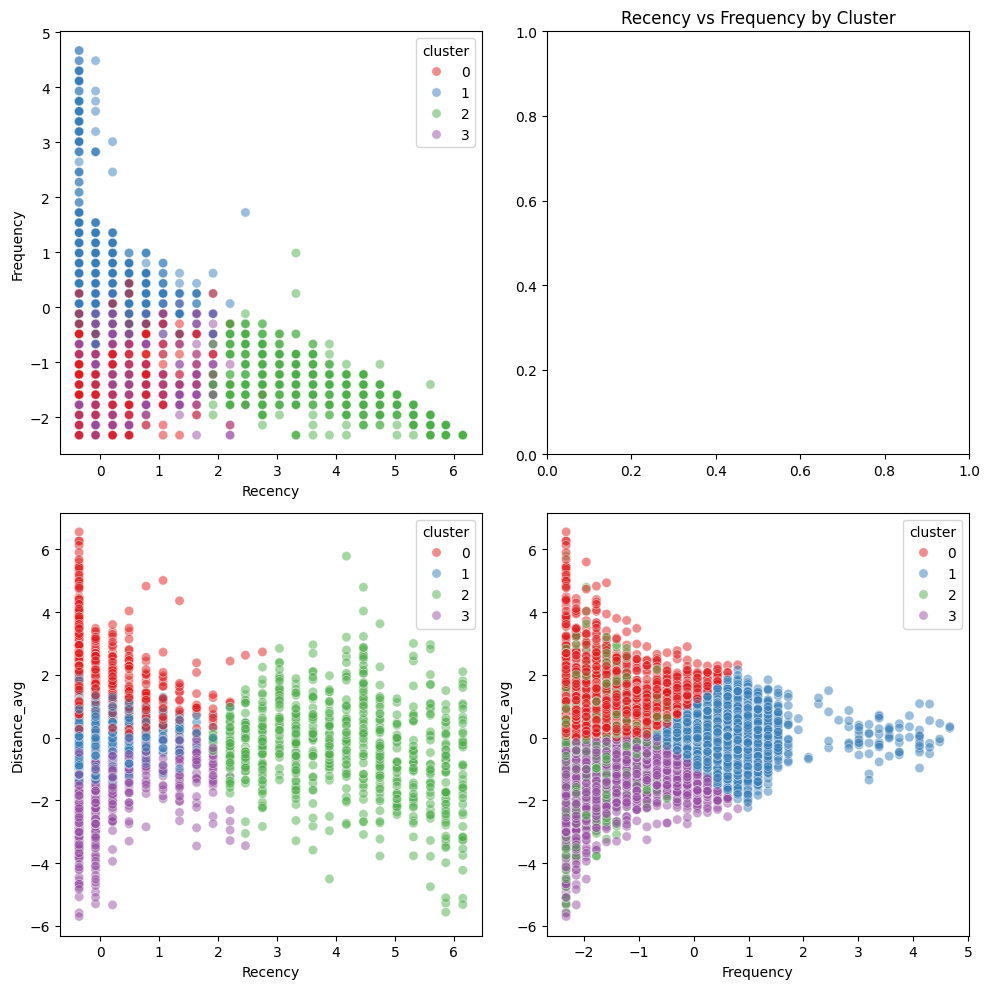

In [206]:
# 兩個維度 vs 分群的點陣圖

# 創建2x2的組圖
fig, axs = plt.subplots(2, 2, figsize=(10, 10))


# 在第1個圖上繪製
sns.scatterplot(x='Recency', y='Frequency',hue='cluster',s=45, data=rfm_normalized, palette='Set1',alpha=0.5,ax=axs[0, 0])
axs[0, 1].set_title('Recency vs Frequency by Cluster')

# 在第3個圖上繪製
sns.scatterplot(x='Recency', y='Distance_avg',hue='cluster',s=45, data=rfm_normalized, palette='Set1',alpha=0.5,ax=axs[1, 0])


# 在第4個圖上繪製
sns.scatterplot(x='Frequency', y='Distance_avg',hue='cluster',s=45, data=rfm_normalized, palette='Set1',alpha=0.5,ax=axs[1, 1])



plt.tight_layout()
plt.show()

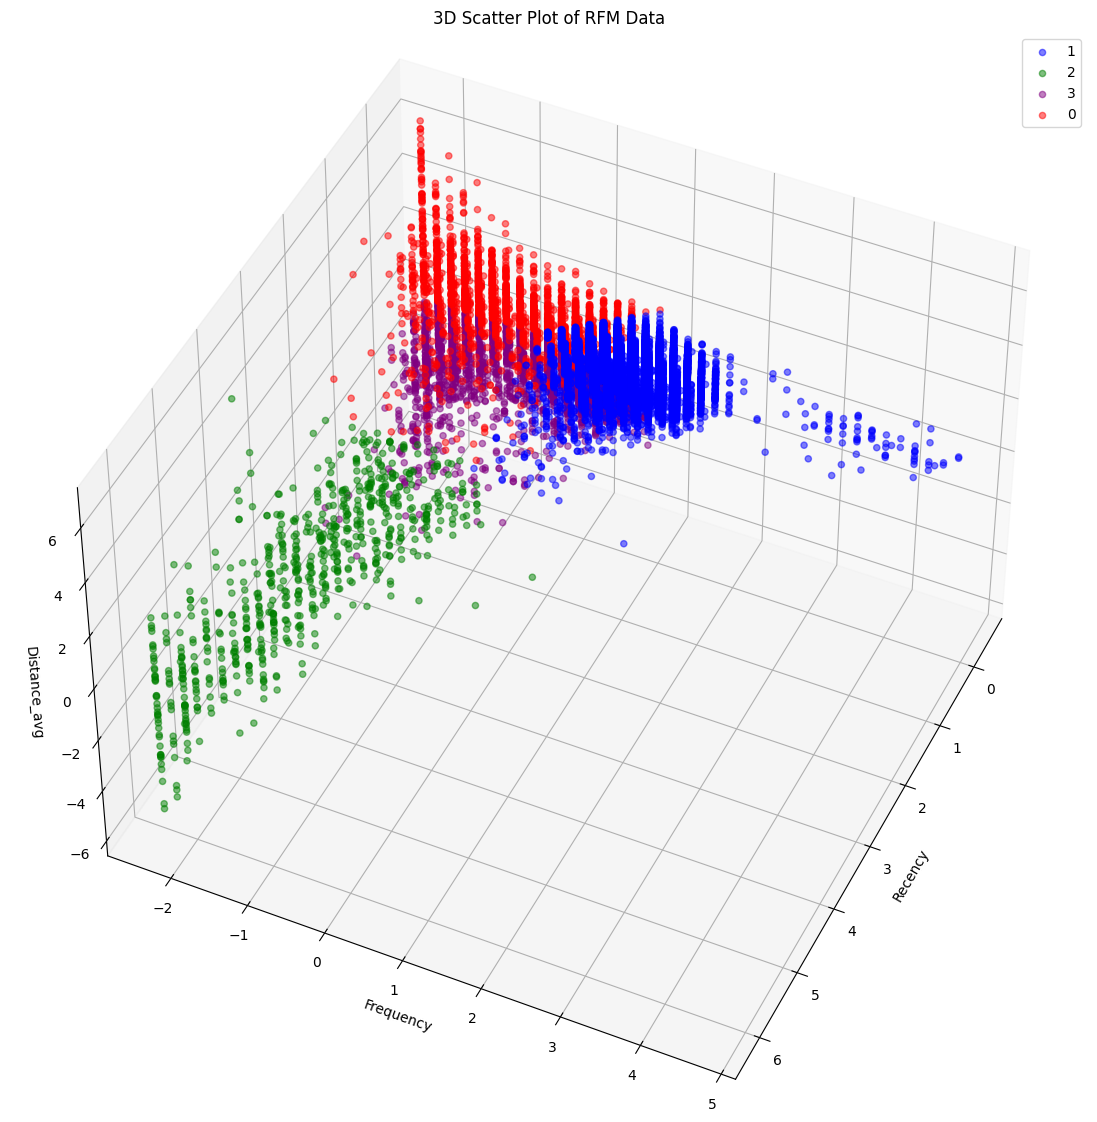

In [207]:
# 三個維度 vs 分群的3D點陣圖


# 創建3D圖形
fig = plt.figure(figsize=(14, 14))
ax = fig.add_subplot(111, projection='3d')


# 為每個群組繪製散點圖
colors = {0: 'r', 1: 'b', 2: 'g', 3: 'purple'}  # 為每個群組指定顏色
for cluster in rfm_normalized['cluster'].unique():
    # 篩選當前群組的數據
    cluster_data = rfm_normalized[rfm_normalized['cluster'] == cluster]
    ax.scatter(cluster_data['Recency'], cluster_data['Frequency'], cluster_data['Distance_avg'], c=colors[cluster], label=cluster, alpha=0.5)


# 調整3D視角
ax.view_init(elev=45, azim=25)


# 設置標籤
ax.legend()
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Distance_avg')

# 設置標題
ax.set_title('3D Scatter Plot of RFM Data')

plt.show()
